In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import sph_harm, genlaguerre
from scipy.constants import physical_constants
import sys
sys.path.append(r'c:\Users\natha\CnuB\CnuB_optics\OneD_stuff')
from OneD_stuff import OneD_Saarik_graph as odsg

ModuleNotFoundError: No module named 'OneD_stuff'

In [9]:
# Constants
hbar = 1.0   # Planck's constant / 2π
m = .1
R = 320
U = 1
distance = (R)*5
earth_cutoff = R / distance

# Based on the condition given in equation 3, the eigenvalue k^2 << (m*U)^3/2 * R in order for there to be a large asymmetry
k_condition = (m*U)**(3/2) * R
print(k_condition)
print((m * 1E-14)**(3/2) * 3.2E13)

# delta negative is neutrino, delta positive is anti-neutrino

# scale earth down a lot to like a few meters, scale k down as well but like not as small compared to earth as it currently is
# base these values off equation 3
#make it very followed and very violated and see what happens as a toy model

# make sure that our largest eigenvalue has to be much greater than 10^-8 (which is k^2) because that allows us to just use the values
# that represent the CnuB IRL
# this can give us a sense of how many points/distance to use actually :)

#actual values:
# R = 3.2E13 1/ev
# U = 1E-14

10.119288512538816
1.0119288512538816e-09


In [10]:
# define derivative matrices

def first_deriv(N, r):
    diags0 = np.zeros(N)

    ddr = np.diag(diags0)

    for i in range(0, ddr.shape[0]):
        if i != 0:
            ddr[i,i-1] = -1
        if i != ddr.shape[0]-1:
            ddr[i,i+1] = 1
    
    delta_x = r[1] - r[0]

    return ddr / (2 * delta_x)



def second_deriv(N, r):
    diags2 = np.full(N, 2)

    d2dr = np.diag(diags2)

    for i in range(0, d2dr.shape[0]):
        if i != 0:
            d2dr[i,i-1] = -1
        if i != d2dr.shape[0]-1:
            d2dr[i,i+1] = -1
    
    delta_x =  r[1] - r[0]

    return d2dr / (delta_x**2)

def normalize(psi):
    norm = np.sqrt(np.sum(np.abs(psi)**2))  # Compute the norm of the vector
    psi_norm = psi / norm  # Normalize the vector
    return psi_norm


In [11]:
# Potentials and Hamiltonian from equation 25


def potential_nu_25(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        
        V_eff_in = (l * (l + 1))/(r[i]**2) + 2 * m * U

        # outside the earth:
        V_eff_out = (l * (l + 1))/(r[i]**2)

        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in
        else:
            H[i,i] = V_eff_out

    return H

def potential_antinu_25(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        V_eff_in_neg = (l * (l + 1))/(r[i]**2) - 2 * m * U

        # outside the earth:
        V_eff_out_neg = (l * (l + 1))/(r[i]**2)
        #print("In, Out neg: ", V_eff_in_neg, V_eff_out_neg)

        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in_neg
        else:
            H[i,i] = V_eff_out_neg

    return H

# create the equation to be solved: Hψ = (k^2)ψ
def Hamiltonian_nu_25(N, r, l):
    H = - second_deriv(N, r) + potential_nu_25(N,r, l)
    return H

def Hamiltonian_antinu_25(N, r, l):
    H = - second_deriv(N, r) + potential_antinu_25(N,r, l)
    return H


In [21]:
def threeD_graph(n, N, l_max, increment):
    theta = np.linspace(0, np.pi, N)
    phi = np.linspace(0, 2*np.pi, N)
    r_values = np.linspace(0.001, distance, N)


    # Create a 3D grid for theta, phi, and r
    theta, phi, r = np.meshgrid(theta, phi, r_values)
    
    sum_psi_nu = np.zeros_like(r_values)
    sum_psi_antinu = np.zeros_like(r_values)
    sum_sph_harm = np.zeros_like(r, dtype=complex)

    for l in range(1, l_max, increment):  # loop over l values in a given increment
        print(f'{(l_max - l)/increment} l values remaining')
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
        
        psi_nu = psi_nu.T
        psi_antinu = psi_antinu.T
        
        # Add the normalized wavefunctions to the sum
        sum_psi_nu += psi_nu[n-1]
        sum_psi_antinu += psi_antinu[n-1]

        # Calculate the spherical harmonics
        Y_lm = sph_harm(0, l, phi, theta)
        sum_sph_harm += Y_lm

    sum_psi_nu_normalized = normalize(sum_psi_nu)
    sum_psi_antinu_normalized = normalize(sum_psi_antinu)

    print(np.sum(np.abs(sum_psi_antinu_normalized)**2))
    print(np.sum(np.abs(sum_psi_nu_normalized)**2))

    asym = []
    for j in range(0, len(r_values)):
        if np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2 and np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == 0:
            asym.append(0)
        else:
            asym.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2)/(np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 + np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2))

    wavefunction_asym = asym# * abs(sum_sph_harm)**2
    # I don't think we actually need to graph asymmetry with the spherical harmonics, but I'm not sure
    wavefunction_nu = sum_psi_nu_normalized * sum_sph_harm
    wavefunction_antinu = sum_psi_antinu_normalized * sum_sph_harm


    # Calculate the probability density
    density = np.abs(wavefunction_asym)**2

    # Calculate the total probability of the wavefunction
    total_prob = np.sum(density)

    # Normalize the wavefunction
    wavefunction_normalized = wavefunction_asym / np.sqrt(total_prob)

    # calculate the density with the normalized wavefunction
    density_normalized = np.abs(wavefunction_normalized)**2


    # Convert to Cartesian coordinates for plotting
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # Create a mask for the slice
    mask = (phi < 6*np.pi/4) | (phi > 8*np.pi/4)

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x[mask], y[mask], z[mask], c=density_normalized[mask], alpha=0.6, s=1)

    # Add a colorbar
    fig.colorbar(sc, ax=ax, label='Asymmetry')

    # Show the plot
    plt.show()

99.0 l values remaining
98.0 l values remaining
97.0 l values remaining
96.0 l values remaining
95.0 l values remaining
94.0 l values remaining
93.0 l values remaining
92.0 l values remaining
91.0 l values remaining
90.0 l values remaining
89.0 l values remaining
88.0 l values remaining
87.0 l values remaining
86.0 l values remaining
85.0 l values remaining
84.0 l values remaining
83.0 l values remaining
82.0 l values remaining
81.0 l values remaining
80.0 l values remaining
79.0 l values remaining
78.0 l values remaining
77.0 l values remaining
76.0 l values remaining
75.0 l values remaining
74.0 l values remaining
73.0 l values remaining
72.0 l values remaining
71.0 l values remaining
70.0 l values remaining
69.0 l values remaining
68.0 l values remaining
67.0 l values remaining
66.0 l values remaining
65.0 l values remaining
64.0 l values remaining
63.0 l values remaining
62.0 l values remaining
61.0 l values remaining
60.0 l values remaining
59.0 l values remaining
58.0 l values re

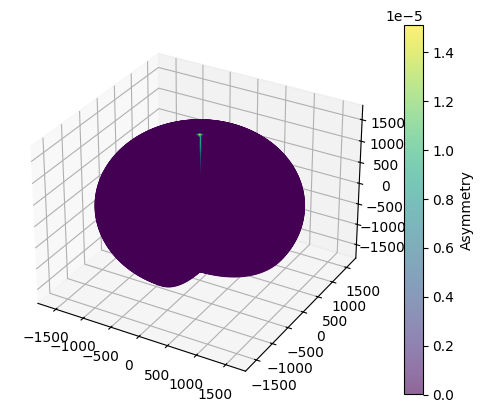

In [23]:
threeD_graph(1, 200, 100, 1)